![title](http://oi65.tinypic.com/2nvf248.jpg)

# Real-Time AdTracking Fraud Detection of 50 Million Clicks.

![title](http://i64.tinypic.com/2he8p7b.jpg)

In [2]:
# Numerical Python and Pandas for data manipulation
import numpy as np
import pandas as pd

In [3]:
# Necessary libraries from Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [4]:
# Visualization
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [5]:
# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost
from xgboost import plot_importance

In [6]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Import data set from Kaggle Competition
Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

The dataset contains approximately 200,000,000 clicks over 4 days!

In [7]:
# Thanks to Bojan Tunguz on Kaggle for suggesting to skip the first 150 million rows.
train = pd.read_csv("train.csv", skiprows=150000000, nrows=50000000)

In [8]:
train.columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed']

In [9]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,111186,12,1,22,178,2017-11-09 05:19:45,NaN,0
1,143839,12,1,17,178,2017-11-09 05:19:45,NaN,0
2,87609,18,1,19,107,2017-11-09 05:19:45,NaN,0
3,123924,2,1,25,469,2017-11-09 05:19:45,NaN,0
4,105861,29,1,19,343,2017-11-09 05:19:45,NaN,0


# Exploring Fraudulent Cases
The basic goal is to see a few rows where fraud (is_attributed = 1) happened. 

Something important stands out: transactions happen 24/7. It's possible, that we need to feature engineer the timestamp with an advanced technique called Sin / Cosine. The reason for this is that the traditional approach of breaking up date data into multiple features might not be sufficient as e.g. 5 minutes before midnight and 5 minutes after midnight are pretty close. By using the traditional Panda date data handling, we would miss this.

In [10]:
# Show the top rows where column 'is_attributed' equals 1
train[train['is_attributed'] == 1].head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
412,322273,29,1,14,213,2017-11-09 05:19:45,2017-11-09 05:21:39,1
627,324343,45,1,61,419,2017-11-09 05:19:45,2017-11-09 05:19:53,1
1212,356183,19,0,24,213,2017-11-09 05:19:46,2017-11-09 05:24:41,1
1329,47595,9,1,15,334,2017-11-09 05:19:46,2017-11-09 07:12:10,1
1344,77041,10,1,13,317,2017-11-09 05:19:46,2017-11-09 09:20:20,1


In [11]:
train.shape

(34903890, 8)

# Class Distribution

In [12]:
# How is the target distributed? 
target_counts = train.groupby('is_attributed').size()
target_counts

is_attributed
0    34815719
1       88171
dtype: int64

# Breaking Up Date Data into Multiple Features
The goal is to break up the timestamp into seperate columns of year, month, day, hour and minute.

In [13]:
df = pd.DataFrame(data=train, columns=['click_time'])

In [14]:
df.click_time = pd.to_datetime(df.click_time)

In [15]:
df['new_formatted_date'] = df.click_time.dt.strftime('%d/%m/%y %H:%M')

In [16]:
df.new_formatted_date.head(3)

0    09/11/17 05:19
1    09/11/17 05:19
2    09/11/17 05:19
Name: new_formatted_date, dtype: object

In [17]:
# pandas.Series.dt
df['month'] = df.click_time.dt.month
df['day'] = df.click_time.dt.day
df['year'] = df.click_time.dt.year
df['hour'] = df.click_time.dt.hour
df['minute'] = df.click_time.dt.minute
df.head(3)

,click_time,new_formatted_date,month,day,year,hour,minute
0,2017-11-09 05:19:45,09/11/17 05:19,11,9,2017,5,19
1,2017-11-09 05:19:45,09/11/17 05:19,11,9,2017,5,19
2,2017-11-09 05:19:45,09/11/17 05:19,11,9,2017,5,19


In [18]:
print('Unique values of month:', df.month.unique())
print('Unique values of day:', df.day.unique())
print('Unique values of year:', df.year.unique())
print('Unique values of hour:', df.hour.unique())
print('Unique values of minute:', df.minute.unique())

Unique values of month: [11]
Unique values of day: [9]
Unique values of year: [2017]
Unique values of hour: [ 5  6  7  8  9 10 11 12 13 14 15 16]
Unique values of minute: [19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42
 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59  0  1  2  3  4  5  6
  7  8  9 10 11 12 13 14 15 16 17 18]


We only have a single month and year. Therefore, we only care about day/hour/minute as a feature.

# The Magic
Now the magic happens. We map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using sin and cos trigonometric functions. You remember your unit circle, right? Here's what it looks like for the "hours" variable. Zero (midnight) is on the right, and the hours increase counterclockwise around the circle. In this way, 23:59 is very close to 00:00, as it should be.

Source: David Kaleko (http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)

![title](http://i65.tinypic.com/2akh56x.jpg)

In [19]:
# Day
df['day_sin'] = np.sin(df.day*(2.*np.pi/30))
df['day_cos'] = np.cos(df.day*(2.*np.pi/30))

In [20]:
# Hour
df['hour_sin'] = np.sin(df.hour*(2.*np.pi/24))
df['hour_cos'] = np.cos(df.hour*(2.*np.pi/24))

In [21]:
# Minute
df['minute_sin'] = np.sin(df.minute*(2.*np.pi/60))
df['minute_cos'] = np.cos(df.minute*(2.*np.pi/60))

# Concatenate Data Frames

In [22]:
# Concatenate
concatenated = pd.concat([train, df], axis=1)

# Define X and y

In [23]:
# Define y = is_attributed
y = concatenated['is_attributed']

In [24]:
# Sanity check
y.head(3)

0    0
1    0
2    0
Name: is_attributed, dtype: int64

In [36]:
# Define X
X = concatenated[['app', 'device', 'os', 'channel', 'hour_sin', 'hour_cos']]

In [37]:
# Sanity check
X.head(3)

,app,device,os,channel,hour_sin,hour_cos
0,12,1,22,178,0.965926,0.258819
1,12,1,17,178,0.965926,0.258819
2,18,1,19,107,0.965926,0.258819


# Split Data into Training and Test Sets


In [38]:
validation_size = 0.10 # 10% is enough for this large dataset
seed = 99
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = validation_size, 
                                                     random_state=seed, shuffle=True )

In [39]:
num_folds = 5
kfold = KFold(n_splits=5, random_state=seed)

# Machine Learning Algorithm

In [47]:
# fit the model to the training data
model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None,
                               random_state=99, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               min_impurity_split=None, class_weight="balanced", presort=False)

In [48]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [49]:
num_folds = 5
seed = 99

kfold = KFold(n_splits=num_folds, random_state=seed)
results = cross_val_score(model, X_test, y_test, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 96.136% (0.018%)


In [50]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [51]:
from sklearn.metrics import classification_report
predicted = model.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   3481661
           1       0.05      0.83      0.10      8728

   micro avg       0.96      0.96      0.96   3490389
   macro avg       0.53      0.90      0.54   3490389
weighted avg       1.00      0.96      0.98   3490389



# Visualizing the Decision Tree

In [52]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [53]:
columns = X.columns.values.tolist()

In [54]:
dot_data = StringIO()
export_graphviz(
    model,
    out_file=dot_data, 
    filled=True,
    rounded=True,
    feature_names=columns,
    class_names=['Low Risk','High Risk'],
    special_characters=True)

In [55]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

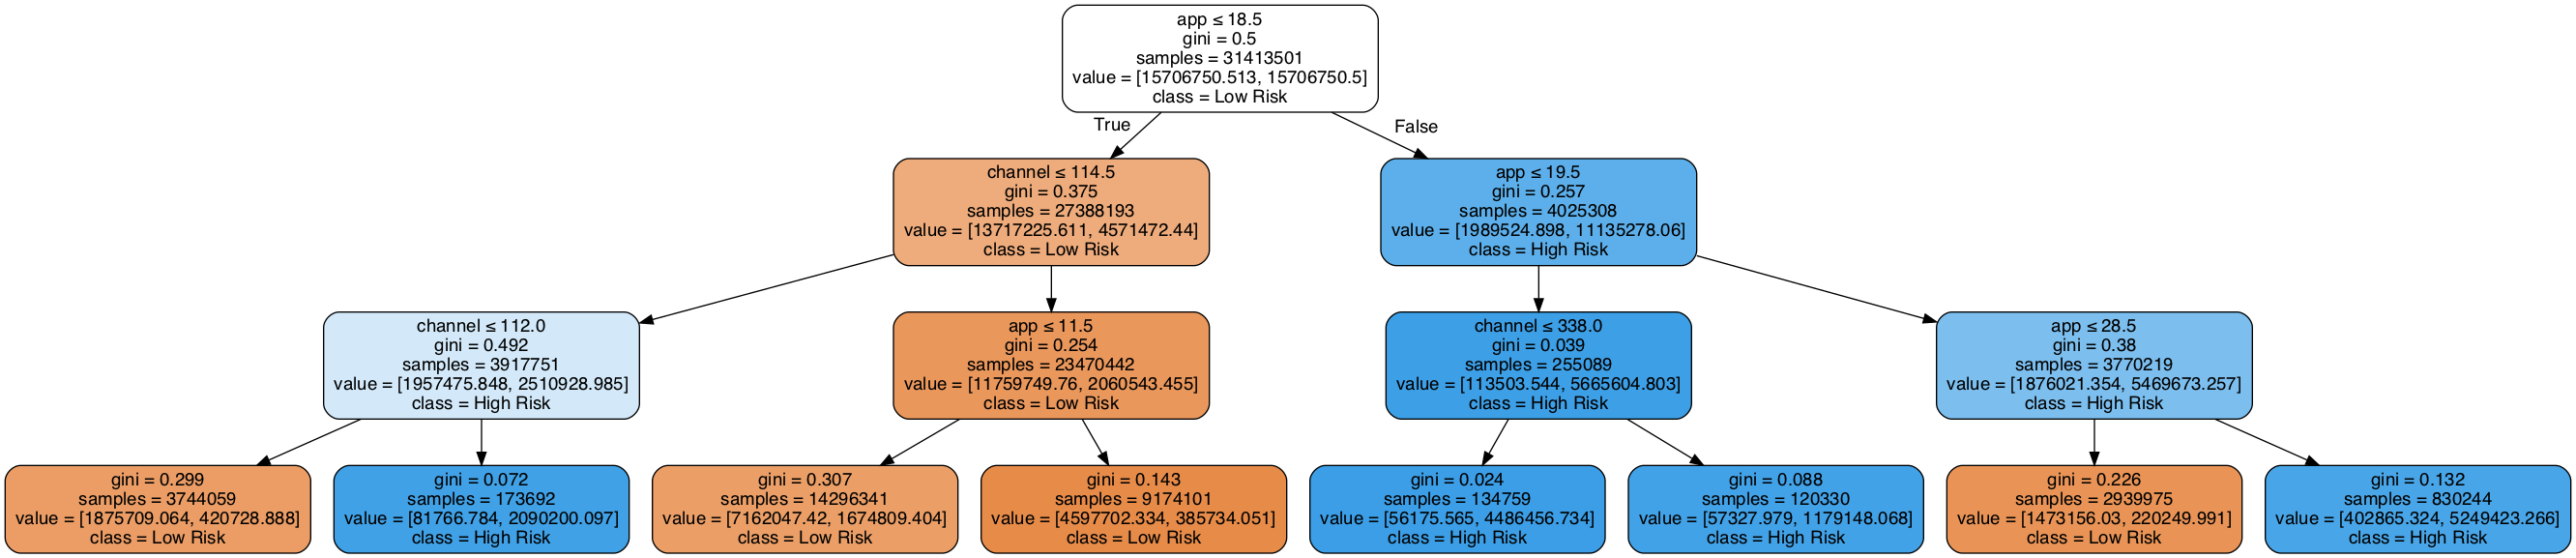

In [56]:
Image(graph.create_png())